# Oil Spill Detection – Data Preprocessing & Visualization

This notebook covers:
- Dataset loading
- Data preprocessing and augmentation
- Class imbalance analysis
- Visualization of images and masks
- Validation of preprocessing pipeline

The goal is to ensure the data is **clean, balanced, and model-ready** before training.


In [96]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import random


In [97]:
TARGET_SIZE = (640, 640)
NUM_CLASSES = 6

CLASS_NAMES = [
    "Background",
    "Emulsion",
    "Oil",
    "Oil-Platform",
    "Sheen",
    "Ship"
]

CLASS_COLORS = {
        0: (173, 216, 230),  
        1: (250, 128, 114),   
        2: (150, 238, 220),   
        3: (255, 165, 0),     
        4: (238, 130, 238),   
        5: (255, 215, 0),     
    }


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

IMG_EXTENSIONS = [".jpg", ".jpeg", ".png"]


## Data Augmentation Strategy

Augmentations are carefully selected to:
- Preserve aerial geometry
- Improve generalization
- Avoid unrealistic transformations


In [98]:
train_transforms = A.Compose([
    A.Resize(*TARGET_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=0,
        p=0.4
    ),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(blur_limit=3, p=0.15),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = A.Compose([
    A.Resize(*TARGET_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


## Dataset Loader

- Supports Roboflow segmentation format
- Loads image–mask pairs
- Applies joint augmentation


In [99]:
class OilSpillDataset(Dataset):
    def __init__(self, root_dir, split="train", transforms=None):
        self.root = Path(root_dir) / split
        self.transforms = transforms

        self.images = sorted([
            p for p in self.root.iterdir()
            if p.suffix.lower() in IMG_EXTENSIONS and "_mask" not in p.name
        ])

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {self.root}")

        print(f"[{split.upper()}] {len(self.images)} samples loaded")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = img_path.with_name(img_path.stem + "_mask.png")

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = np.array(Image.open(mask_path), dtype=np.int64)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return image, mask


## Dataset Initialization


In [100]:
ROOT = "/kaggle/input/oil-spill-raw-segmentation"

train_ds = OilSpillDataset(ROOT, "train", train_transforms)
val_ds   = OilSpillDataset(ROOT, "valid", val_transforms)


[TRAIN] 2370 samples loaded
[VALID] 675 samples loaded


## discover imbalance class 

In [101]:
from collections import defaultdict, Counter

def discover_mask_colors(ROOT, max_samples=50):

    dataset_root = Path(ROOT)
    colors_counter = Counter()
    unique_colors_set = set()

    print("Discovering colors in your masks...")

    for split in ['train', 'valid', 'test']:
        split_path = dataset_root / split

        if not split_path.exists():
            print(f"⚠️ {split} folder not found, skipping...")
            continue

       
        mask_files = list(split_path.glob("*_mask.png"))

        if not mask_files:
            mask_files = list(split_path.glob("*_mask.jpg"))

        print(f"  Found {len(mask_files)} mask files in {split}")

    
        if len(mask_files) > max_samples:
            selected_files = np.random.choice(mask_files, max_samples, replace=False)
        else:
            selected_files = mask_files

    
        for mask_file in selected_files:
            mask = cv2.imread(str(mask_file))
            if mask is None:
                continue

            
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            
            pixels = mask.reshape(-1, 3)

            for pixel in pixels:
                color_tuple = tuple(pixel)
                colors_counter[color_tuple] += 1
                unique_colors_set.add(color_tuple)

    print(f"\n Found {len(unique_colors_set)} unique colors")
    print("Top 10 most common colors:")

    for color, count in colors_counter.most_common(10):
        print(f"  {color}: {count:,} pixels")

    return colors_counter, unique_colors_set


colors_counter, unique_colors = discover_mask_colors(ROOT, max_samples=30)

Discovering colors in your masks...
  Found 2370 mask files in train
  Found 675 mask files in valid
  Found 343 mask files in test

 Found 6 unique colors
Top 10 most common colors:
  (np.uint8(0), np.uint8(0), np.uint8(0)): 16,565,121 pixels
  (np.uint8(2), np.uint8(2), np.uint8(2)): 8,795,980 pixels
  (np.uint8(1), np.uint8(1), np.uint8(1)): 7,606,506 pixels
  (np.uint8(4), np.uint8(4), np.uint8(4)): 3,551,011 pixels
  (np.uint8(5), np.uint8(5), np.uint8(5)): 297,894 pixels
  (np.uint8(3), np.uint8(3), np.uint8(3)): 47,488 pixels


## Class Imbalance Analysis

Oil spill datasets are highly imbalanced.
We compute pixel-wise class weights to address this issue.


In [102]:
def compute_class_weights(dataset):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)

    for _, mask in tqdm(dataset, desc="Computing class weights"):
        ids, freqs = np.unique(mask.numpy(), return_counts=True)
        for i, f in zip(ids, freqs):
            if i < NUM_CLASSES:
                counts[i] += f

    freq = counts / counts.sum()
    weights = 1.0 / (np.sqrt(freq) + 1e-6)
    weights = weights / weights.mean()

    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(train_ds)

for i, w in enumerate(class_weights):
    print(f"{CLASS_NAMES[i]}: {w:.4f}")


Computing class weights: 100%|██████████| 2370/2370 [00:39<00:00, 59.33it/s]

Background: 0.1271
Emulsion: 0.2103
Oil: 0.1952
Oil-Platform: 4.3923
Sheen: 0.2453
Ship: 0.8298


In [103]:
def build_weighted_sampler(dataset, class_weights):
    sample_weights = []

    for _, mask in dataset:
        ids, counts = np.unique(mask.numpy(), return_counts=True)
        proportions = counts / counts.sum()

        weight = sum(
            prop * class_weights[cls].item()
            for cls, prop in zip(ids, proportions)
            if cls < len(class_weights)
        )

        sample_weights.append(weight)

    return WeightedRandomSampler(
        sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

## Segmentation Mask Decoding

In [104]:
def decode_mask(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in CLASS_COLORS.items():
        rgb[mask == cls] = color
    return rgb

def overlay_mask(image, mask_rgb, alpha=0.5):
    return cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)

# Visualization

 ##  visualize after augmentation

Visualizing Augmented Sample...


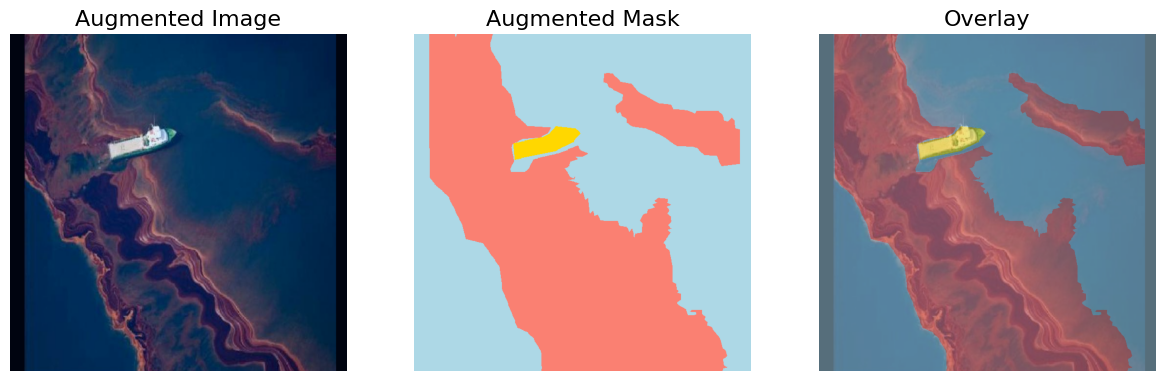

In [112]:
def visualize_after_augmentation(dataset, idx=0):
    image, mask = dataset[idx]

    
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min() + 1e-6)
    image = (image * 255).astype(np.uint8)

    mask = mask.numpy()
    mask_rgb = decode_mask(mask)
    overlay = overlay_mask(image, mask_rgb)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Augmented Image", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis("off") 

    plt.subplot(1, 4, 2)
    plt.imshow(mask_rgb)
    plt.title("Augmented Mask", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(overlay)
    plt.title("Overlay", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis("off")
print("Visualizing Augmented Sample...")
random_idx = random.randint(0, len(train_ds)-1)
visualize_after_augmentation(train_ds, idx=random_idx)

##  Visual Inspection of Preprocessed Samples 

In [106]:
def plot_class_distribution(mask):
    ids, counts = np.unique(mask, return_counts=True)
    labels = [CLASS_NAMES[i] for i in ids]
    colors = [np.array(CLASS_COLORS[i]) / 255 for i in ids]
    plt.bar(labels, counts, color=colors)
    plt.title("Pixel-wise Class Distribution")
    plt.ylabel("Pixel Count")
    plt.xticks(rotation=30)

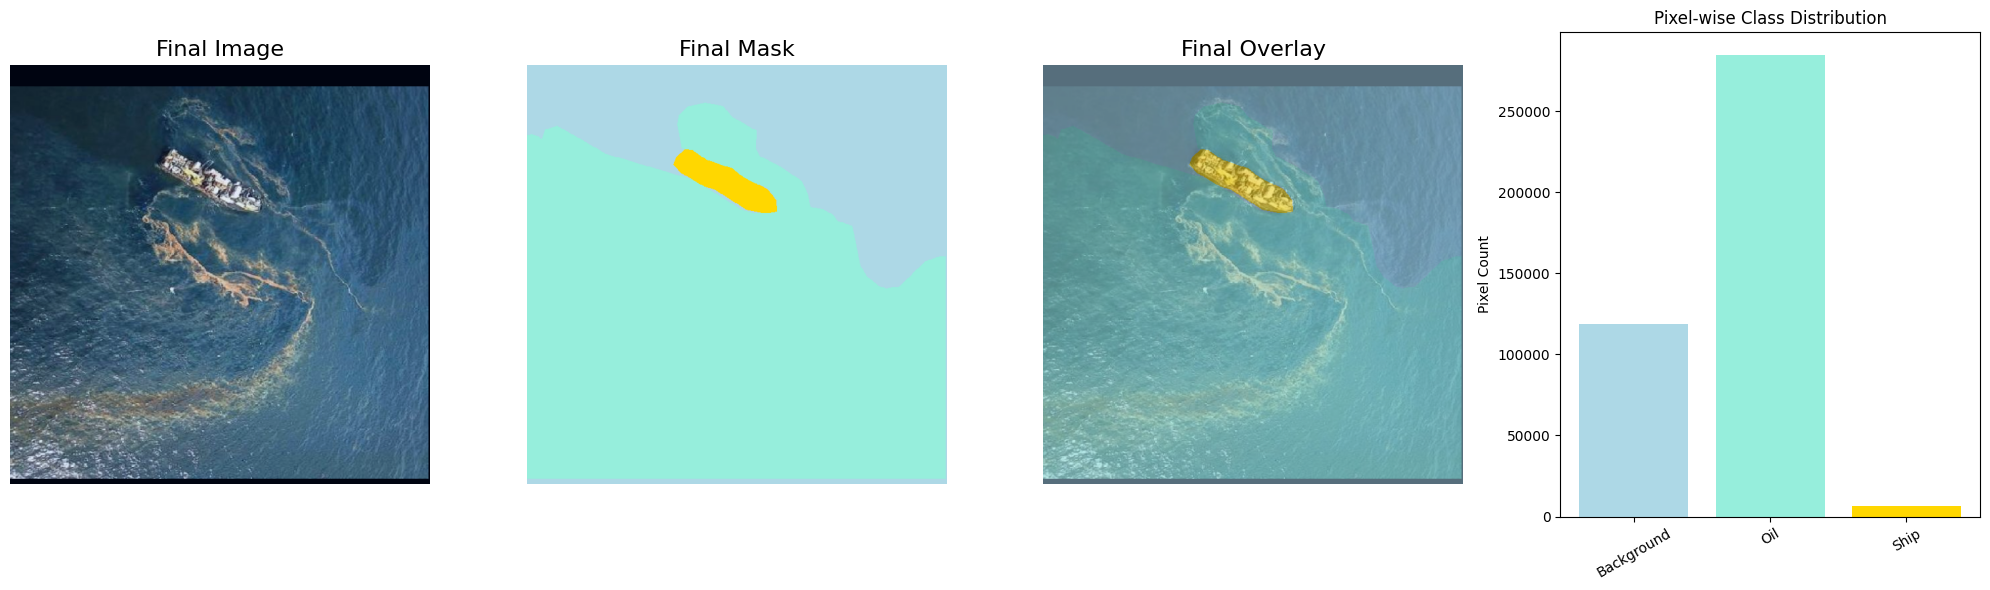

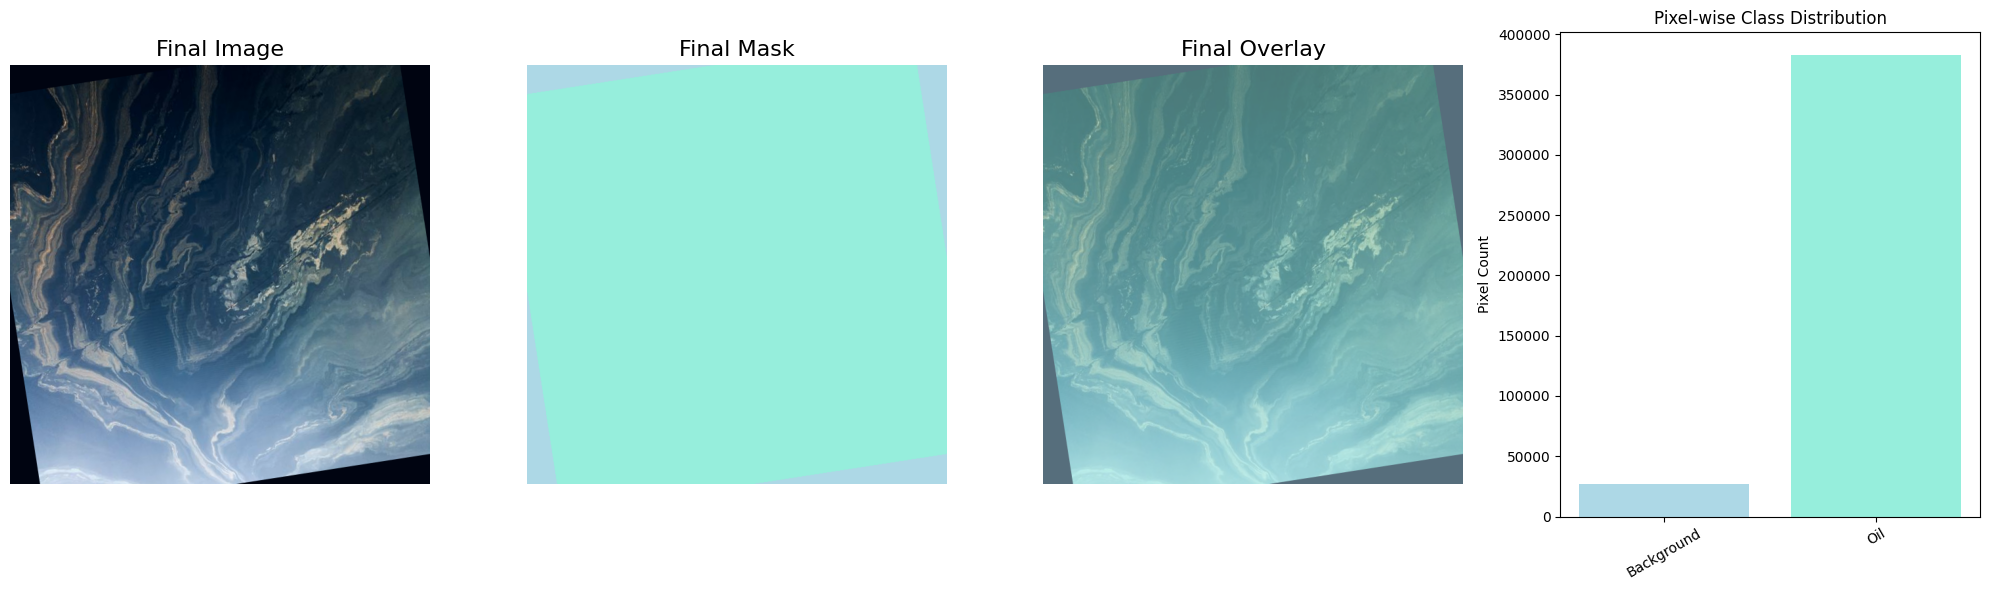

In [107]:
def visualize_final_preprocessing(dataset, n_samples=2):
    for i in range(n_samples):
        image, mask = dataset[i]

        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)
        image = (image * 255).astype(np.uint8)

        mask = mask.numpy()
        mask_rgb = decode_mask(mask)
        overlay = overlay_mask(image, mask_rgb)

        plt.figure(figsize=(20, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.title("Final Image",fontsize=16)
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(mask_rgb)
        plt.title("Final Mask" ,fontsize=16)
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(overlay)
        plt.title("Final Overlay",fontsize=16)
        plt.axis("off")
        
        plt.subplot(1, 4, 4)
        plot_class_distribution(mask)
        plt.tight_layout()
        plt.show()

visualize_final_preprocessing(train_ds, n_samples=2)

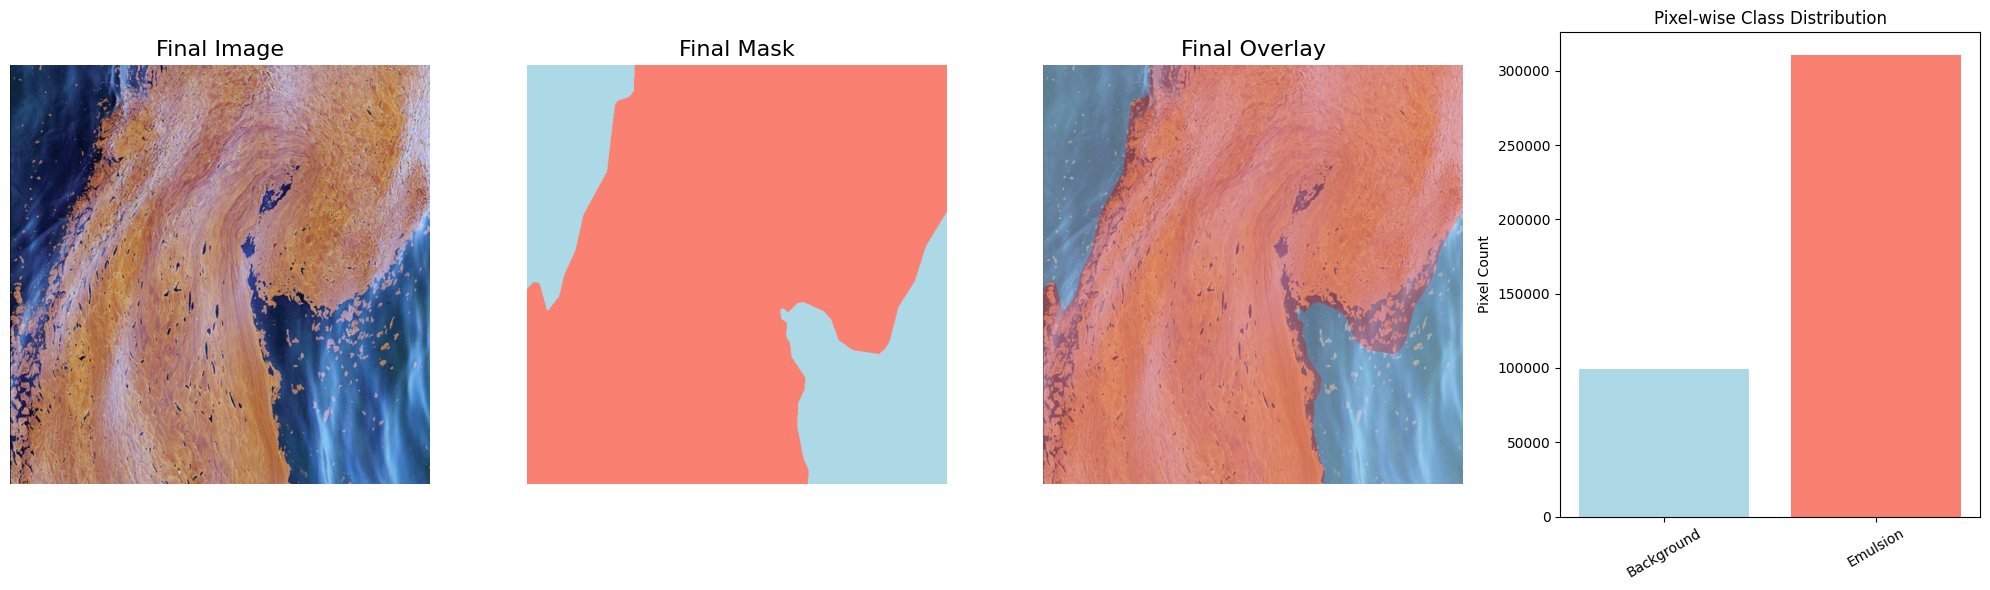

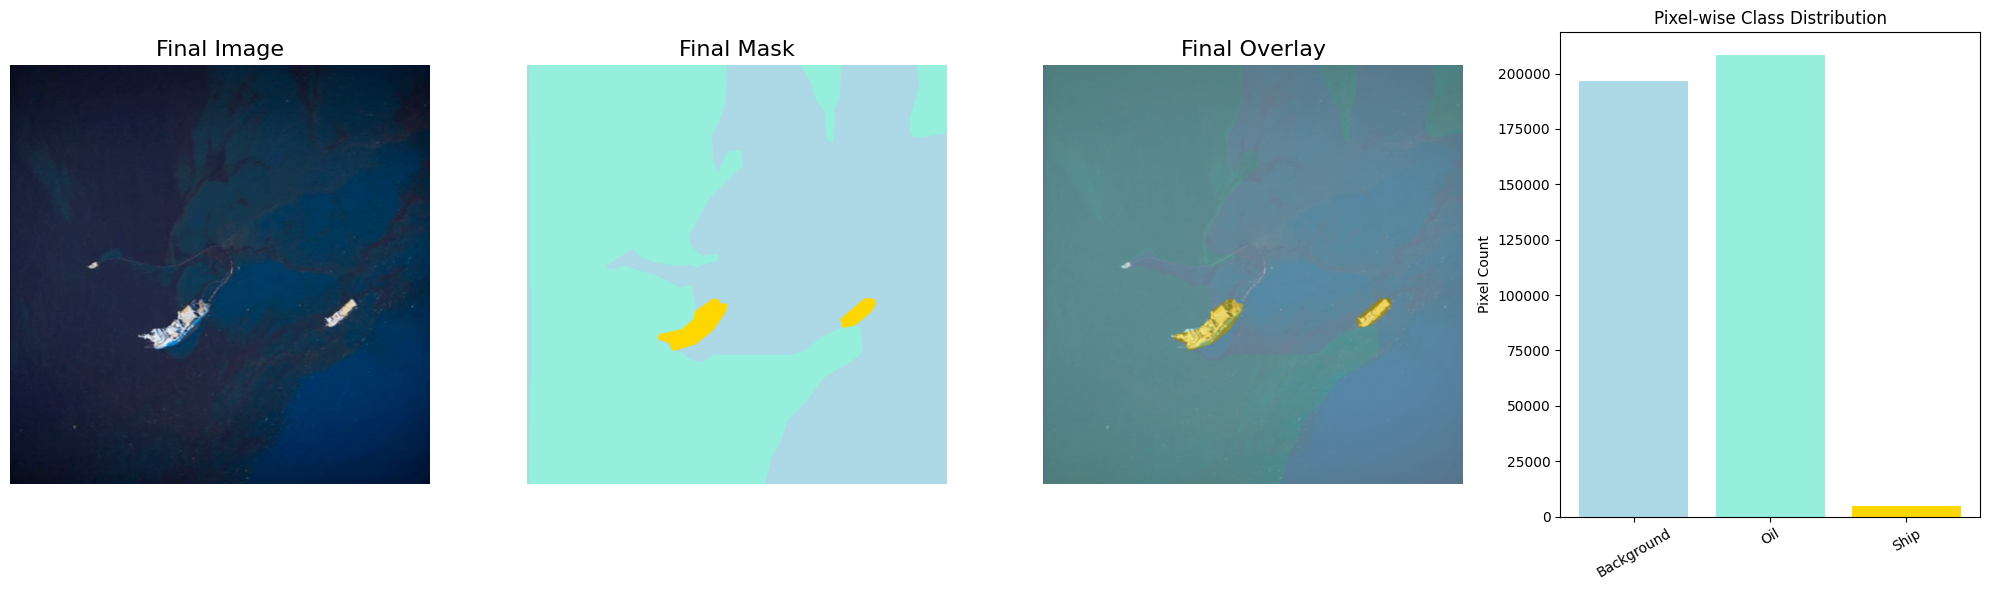

In [108]:
visualize_final_preprocessing(val_ds, n_samples=2)

## Dataset Statistics Visualization


Total samples: 2370
Background: 10876854 pixels (53.11%)
Emulsion: 4173596 pixels (20.38%)
Oil: 5134571 pixels (25.07%)
Oil-Platform: 0 pixels (0.00%)
Sheen: 0 pixels (0.00%)
Ship: 294979 pixels (1.44%)


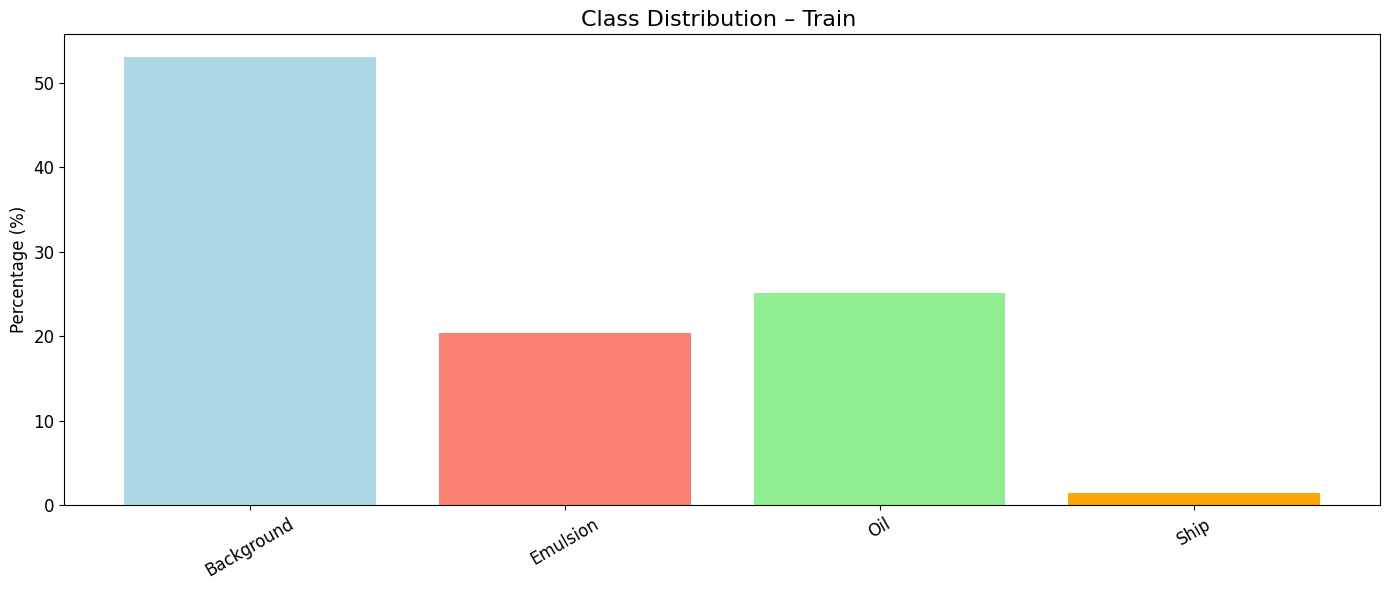

Total samples: 675
Background: 127662187 pixels (46.17%)
Emulsion: 50938708 pixels (18.42%)
Oil: 61505901 pixels (22.25%)
Oil-Platform: 213135 pixels (0.08%)
Sheen: 33313591 pixels (12.05%)
Ship: 2846478 pixels (1.03%)


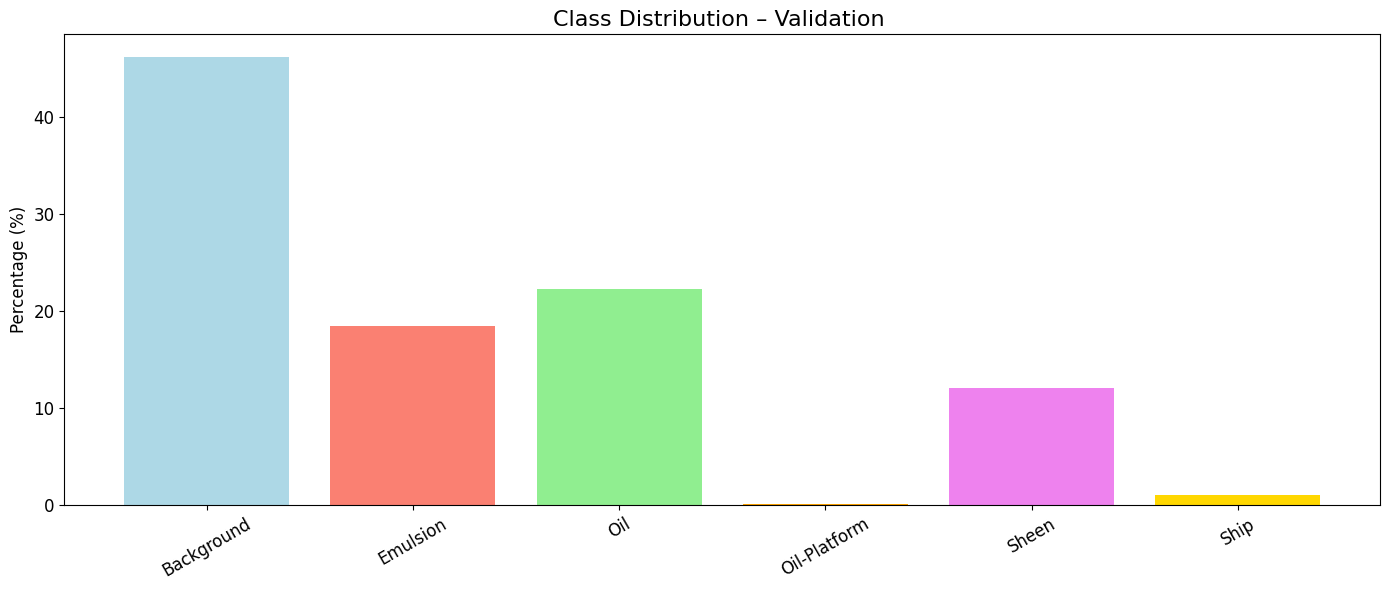

In [109]:
def summarize_dataset(dataset, split_name,class_to_color=CLASS_COLORS, class_names=CLASS_NAMES , n_samples=None):

    num_classes = len(class_names)

    total_class_counts = np.zeros(num_classes, dtype=np.int64)
    total_images = len(dataset)

    
    if n_samples is None:
        n_samples = total_images

    for i in range(n_samples):
        _, mask = dataset[i]
        mask = mask.numpy()
        ids, counts = np.unique(mask, return_counts=True)
        for cid, cnt in zip(ids, counts):
            if cid < num_classes:
                total_class_counts[cid] += cnt

    total_pixels = total_class_counts.sum()
    class_percent = (total_class_counts / total_pixels) * 100

    print(f"Total samples: {total_images}")
    for cls_id in range(num_classes):
        print(f"{class_names[cls_id]}: {total_class_counts[cls_id]} pixels ({class_percent[cls_id]:.2f}%)")

    
    plot_classes = [cls_id for cls_id in range(num_classes) if total_class_counts[cls_id] > 0]
    names = [class_names[c] for c in plot_classes]
    values = [class_percent[c] for c in plot_classes]


    vis_colors = ['lightblue', 'salmon', 'lightgreen', 'orange', 'violet', 'gold']
    colors = vis_colors[:len(plot_classes)]

    plt.figure(figsize=(14,6))
    plt.bar(names, values, color=colors)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.title(f"Class Distribution – {split_name} ", fontsize=16)
        
    plt.xticks(rotation=30, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    
summarize_dataset(train_ds, "Train", n_samples=50)
summarize_dataset(val_ds, "Validation")


## data loaders


In [ ]:
print("\n" + "="*70)
print("STEP 12: ")
print("="*70)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Summary

- Dataset integrity verified
- Augmentations validated
- Class imbalance analyzed
- Preprocessing pipeline ready for model training
